<a href="https://colab.research.google.com/github/ia-ML/iaGANs/blob/main/iaGANs002_DC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional Generative Adversarial Network (DCGAN)

This is a seies of notebook tutorials about different GANs types, the sources are provided via links within the content or at the last section. If you have correction, feedback or questions please use the github [discussions](https://github.com/ia-ML/iaGANs/discussions) section. The code inside the folders can be used locally.

 ## Introduction:

 This work replaces the use of [fully connected layers]() with convolutional layers which is more suitable for images. The work is described in [Radford et al. 2016](https://arxiv.org/abs/1511.06434).


 ![](https://pytorch.org/tutorials/_images/dcgan_generator.png)



## Pytorch Example: Fully connected GAN

This GAN uses MNIST dataset to generates hand writing digits. The Gan can have one or more fully connected layers. The parameter num_hidden_layers control the number of lyers.

### Model

In [1]:
"""
Discriminator and Generator implementation from DCGAN paper

Programmed by Aladdin Persson <aladdin.persson at hotmail dot com>
* 2020-11-01: Initial coding
* 2022-12-20: Small revision of code, checked that it works with latest PyTorch version
"""
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img     , features_d    , 4, 2, 1),  # 32x32
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d     , features_d * 2, 4, 2, 1),  # 16x16
            self._block(features_d * 2 , features_d * 4, 4, 2, 1),  # 8x8
            self._block(features_d * 4 , features_d * 8, 4, 2, 1),  # 4x4
            nn.Conv2d(  features_d * 8 ,       1       , 4, 2, 0),  # 1 x 1
            nn.Sigmoid(), # result in range 0,1
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential( nn.Conv2d( in_channels, out_channels, kernel_size, stride, padding, bias=False, ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),  )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise   , features_g * 16,  4, 1, 0),  # img: 4x4
            self._block(features_g * 16  , features_g * 8,   4, 2, 1),  # img: 8x8
            self._block(features_g * 8   , features_g * 4,   4, 2, 1),  # img: 16x16
            self._block(features_g * 4   , features_g * 2,   4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(features_g * 2, channels_img, 4, 2, 1),  # img: 64x64
            # Output: N x channels_img x 64 x 64
            nn.Tanh(), # map to a range [-1,1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(nn.ConvTranspose2d( in_channels, out_channels, kernel_size, stride, padding, bias=False,),
                  nn.BatchNorm2d(out_channels),
                  nn.ReLU(), )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
    print("Success, tests passed!")


### Training

In [2]:
"""
Training of DCGAN network on MNIST dataset with Discriminator
and Generator imported from models.py

Programmed by Aladdin Persson <aladdin.persson at hotmail dot com>
* 2020-11-01: Initial coding
* 2022-12-20: Small revision of code, checked that it works with latest PyTorch version
"""
import os, time, shutil
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

print("torch version: ", torch.__version__)
print("torch GPU    : ", torch.cuda.is_available())


# Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc

IMAGE_SIZE    = 64
CHANNELS_IMG  = 1
BATCH_SIZE    = 128

NOISE_DIM     = 100

NUM_EPOCHS    = 5
FEATURES_DISC = 64
FEATURES_GEN  = 64
output_folder = "generated_images"  # Name of the output folder
log_folder    = "logs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
else:
   # Reset
   shutil.rmtree(output_folder)
   os.makedirs(output_folder)

if os.path.exists(log_folder):
   # Reset
   shutil.rmtree(log_folder)

transforms = transforms.Compose(    [
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize( [0.5 for _ in range(CHANNELS_IMG)],
                              [0.5 for _ in range(CHANNELS_IMG)]   ),    ]
)

dataset = datasets.MNIST(    root="dataset/", train=True, transform=transforms, download=True)

# comment mnist above and uncomment below if train on CelebA
# dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen        = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc       = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen   = optim.Adam(gen.parameters(),  lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc  = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
disc.train()
sTm = time.time()
for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real      = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

        disc_fake      = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        loss_disc      = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output   = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )
            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

                # Convert grid to a matplotlib compatible array
                img_array = img_grid_fake.permute(1, 2, 0).cpu().numpy()
                fig, ax = plt.subplots()  # Create a figure and axis
                ax.imshow(img_array)
                ax.axis('off')  # Remove axis for a cleaner look
                plt.savefig(os.path.join(output_folder, f"fake_images_epoch_{epoch}.png"))
                plt.close(fig)  # Close the figure

            step += 1
eTm = time.time()
print("Time: ", eTm-sTm, " seconds!")
print("all tasks are done!")

torch version:  2.2.1+cu121
torch GPU    :  True


100%|██████████| 9912422/9912422 [00:00<00:00, 120004939.37it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40191006.58it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31488541.73it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22733327.89it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

Epoch [0/5] Batch 0/469                   Loss D: 0.6956, loss G: 0.7792
Epoch [0/5] Batch 100/469                   Loss D: 0.0145, loss G: 4.1507
Epoch [0/5] Batch 200/469                   Loss D: 0.6566, loss G: 0.8190
Epoch [0/5] Batch 300/469                   Loss D: 0.5735, loss G: 1.2939
Epoch [0/5] Batch 400/469                   Loss D: 0.5937, loss G: 1.2521
Epoch [1/5] Batch 0/469                   Loss D: 0.5950, loss G: 0.9044
Epoch [1/5] Batch 100/469                   Loss D: 0.8221, loss G: 1.3380
Epoch [1/5] Batch 200/469                   Loss D: 0.6223, loss G: 0.8026
Epoch [1/5] Batch 300/469                   Loss D: 0.6182, loss G: 0.7161
Epoch [1/5] Batch 400/469                   Loss D: 0.6084, loss G: 0.7785
Epoch [2/5] Batch 0/469                   Loss D: 0.5957, loss G: 1.3285
Epoch [2/5] Batch 100/469                   Loss D: 0.9365, loss G: 0.4563
Epoch [2/5] Batch 200/469    

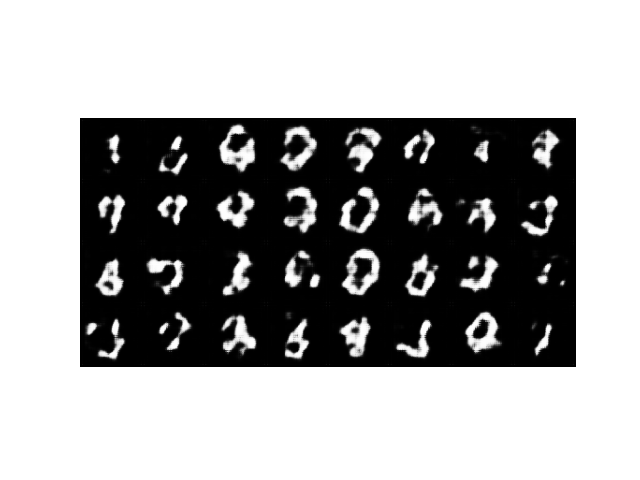

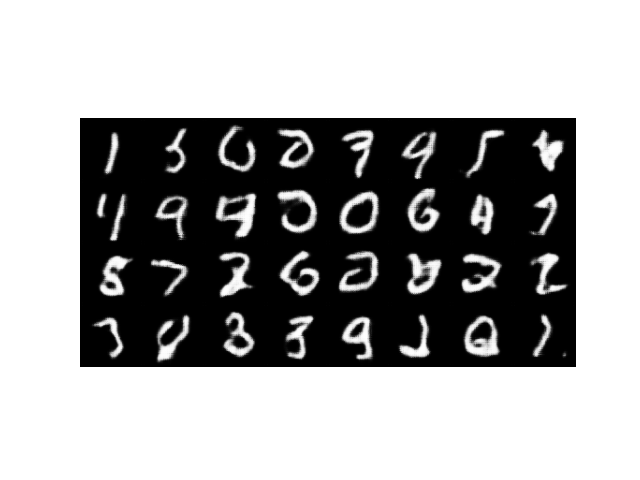

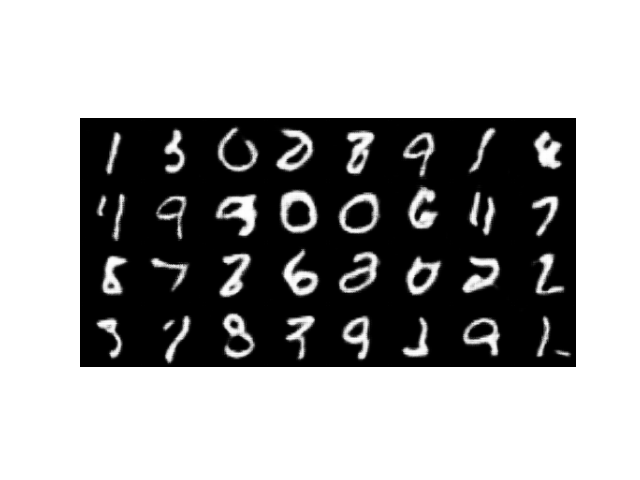

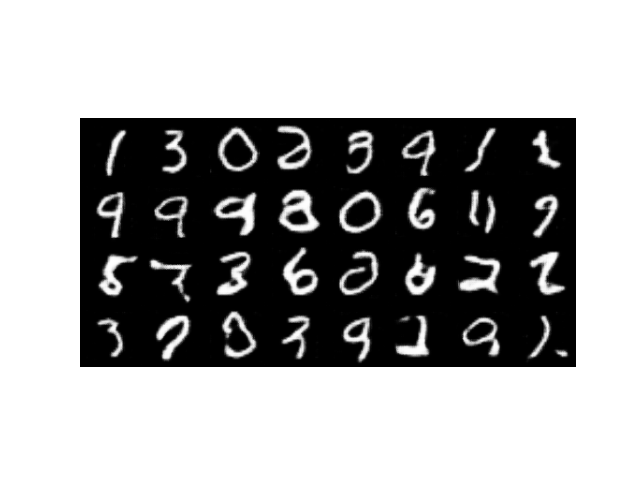

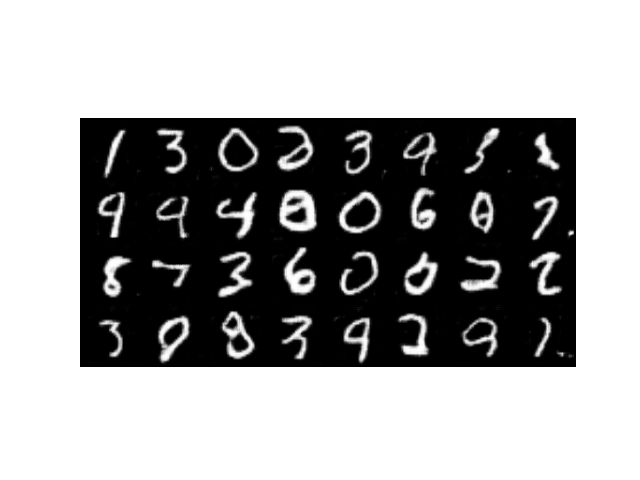

In [3]:
# Display the result:
from PIL import Image
from IPython.display import display
num_epochs = 5

# Load and display an image
for epoch in range(num_epochs):  # Assuming you want to display images from all epochs
    image_path = os.path.join(output_folder, f"fake_images_epoch_{epoch}.png")
    img = Image.open(image_path)
    display(img)


## Resources:

*  DCGAN implementation from scratch . [Video](https://youtu.be/IZtv9s_Wx9I?si=FUJcIXL6E2u1HCK4), [Code.](https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/2.%20DCGAN)
* [celeba-dataset all](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset)
  - 202,599 number of face images of various celebrities
  - 10,177 unique identities, but names of identities are not given
  - 40 binary attribute annotations per image
  - 5 landmark locations
  * Data Files:
    - img_align_celeba.zip: All the face images, cropped and aligned
    - list_eval_partition.csv: Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are - training, 162771-182637 are validation, 182638-202599 are testing
    - list_bbox_celeba.csv: Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box
    - list_landmarks_align_celeba.csv: Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth
    - list_attr_celeba.csv: Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative
* [celeba-dataset images only](https://www.kaggle.com/datasets/504743cb487a5aed565ce14238c6343b7d650ffd28c071f03f2fd9b25819e6c9)
* [dcgan_faces_tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)